In [0]:
%matplotlib inline

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.layers import Input, Flatten, Activation, RepeatVector
from tensorflow.keras.layers import Permute, multiply, Lambda, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import LambdaCallback
from keras import backend as K

from tensorflow.keras import optimizers

import tensorflow as tf

from sklearn.utils import class_weight

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import random
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd

import time
import math

In [0]:
# Helper function to plot results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
# Load data.
adr_data_train_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/adr_data_filtered_train.csv?token=AHRDF6JLLQOK4C2QJDUP7Q2576RAE"
adr_data_test_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/adr_data_filtered_test.csv?token=AHRDF6KG265LUVFIRVH2BTC576Q7I"
adr_data_unlabeled_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/adr_data_unlabeled.csv?token=AHRDF6JXAFCABWSEYEDOCE2576RAY"

adr_data_train = pd.read_csv(adr_data_train_url)
adr_data_test = pd.read_csv(adr_data_test_url)
adr_data_unlabeled = pd.read_csv(adr_data_unlabeled_url)

max_len_train = max(list(map(len, adr_data_train["smile"])))
max_len_test = max(list(map(len, adr_data_test["smile"])))
max_len_unlabeled = max(list(map(len, adr_data_unlabeled["smile"])))
max_len = max(max_len_train, max_len_test, max_len_unlabeled)

print("Max Length Train: " + str(max_len_train))
print("Max Length Test: " + str(max_len_test))
print("Max Length Unlabeled: " + str(max_len_unlabeled))

Max Length Train: 476
Max Length Test: 852
Max Length Unlabeled: 1695


In [0]:
# Constants
NUM_CHARS = 128
INPUT_SIZE = max_len
MAX_LENGTH = max_len
HIDDEN_SIZE = 50
EMBEDDING_SIZE = 64
NUM_LAYERS = 2
NUM_ADR_CLASSES = 27

metric_AUC = tf.keras.metrics.AUC()

In [0]:
def encode_adr_vector(adr_str):
    # Compute indices (1-27) and subtract 1 to make them 0-indexed.
    indices = np.array(list(map(int, adr_str.split(", ")))) - np.array(1)
    # Create one hot vectors of indices (https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array)
    # and sum them to get one 27-bit binary vector.
    one_hot_vecs = np.zeros((indices.size, NUM_ADR_CLASSES))
    one_hot_vecs[np.arange(indices.size),indices] = 1
    encoded_vec = np.sum(one_hot_vecs, axis=0)
    return encoded_vec

In [0]:
def plot_results(model, title="Results", val=False, mlp=False):
    start = 0
    if mlp:
        start = 1
    plt.plot(model.history.history['acc'][start:])
    if val:
        plt.plot(model.history.history['val_acc'][start:])
    plt.plot(model.history.history['loss'][start:])
    if val:
        plt.plot(model.history.history['val_loss'][start:])
    plt.title(title)
    if val:
        plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc = 'best')
    else:
        plt.legend(['train_acc', 'train_loss'], loc = 'best')
    plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    plt.show()

In [0]:
# X-values are SMILE strings, encoded as tensors of ASCII values.
# Y-values are 27-bit binary vectors (1 indicates ADR of that class, 0 indicates not).
X_train = []
y_train = []
X_test = []
y_test = []
X_unlabeled = []

for index, row in adr_data_train.iterrows():
    X_train.append(list(map(ord, row["smile"])))
    y_train.append(encode_adr_vector(row["adrs"]))
for index, row in adr_data_test.iterrows():
    X_test.append(list(map(ord, row["smile"])))
    y_test.append(encode_adr_vector(row["adrs"]))

for index, row in adr_data_unlabeled.iterrows():
    X_unlabeled.append(list(map(ord, row["smile"])))

X_train = sequence.pad_sequences(np.array(X_train), maxlen=MAX_LENGTH, padding="post")
y_train = np.array(y_train)
X_test = sequence.pad_sequences(np.array(X_test), maxlen=MAX_LENGTH, padding="post")
y_test = np.array(y_test)

X_unlabeled = sequence.pad_sequences(np.array(X_unlabeled), maxlen=MAX_LENGTH, padding="post")

In [224]:
y_train[0]

array([1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])

In [0]:
# Generate train main-validation split (80-20).
X_train_main, X_train_val, y_train_main, y_train_val = train_test_split(np.array(X_train), np.array(y_train), train_size=0.8, test_size=0.2)

In [0]:
# Pseudo labeling
def pseudo_labeling(model, iterations, num_epochs, batch_size):
    test_losses = []
    test_accs = []
    for count in range(iterations):
        X_unlabeled_sample = X_unlabeled[np.random.choice(
            X_unlabeled.shape[0], size=300, replace=False)]

        pseudo_labels = np.round(model.predict(X_unlabeled_sample))  
        X_combined = np.concatenate((X_train_main, X_unlabeled_sample), axis=0)
        y_combined = np.concatenate((y_train_main, pseudo_labels), axis=0)
            
        model.fit(X_combined, y_combined,
                            validation_data=(X_train_val, y_train_val),
                            epochs=num_epochs, batch_size=batch_size)
        
        model.evaluate(X_train_main, y_train_main)
        model.evaluate(X_unlabeled_sample, pseudo_labels)
        model.evaluate(X_combined, y_combined)
        loss, acc = model.evaluate(X_test, y_test)
        test_losses.append(loss)
        test_accs.append(acc)
    return test_losses, test_accs


In [0]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
conv_net = Sequential()
conv_net.add(Embedding(NUM_CHARS, 32, input_length=MAX_LENGTH))
conv_net.add(Conv1D(64, 3, activation='relu'))
conv_net.add(Dropout(0.5))
conv_net.add(Conv1D(64, 3, activation='relu'))
conv_net.add(MaxPooling1D(3))
conv_net.add(Conv1D(128, 3, activation='relu'))
conv_net.add(Dropout(0.5))
conv_net.add(Conv1D(128, 3, activation='relu'))
conv_net.add(GlobalAveragePooling1D())
conv_net.add(Dropout(0.5))
conv_net.add(Dense(NUM_ADR_CLASSES, activation='sigmoid'))

conv_net.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

conv_net.fit(X_train, y_train, batch_size=64, epochs=50)

Train on 944 samples
Epoch 1/50
944/944 [==============================] - 1s 990us/sample - loss: 0.5705 - acc: 0.7192
Epoch 2/50
944/944 [==============================] - 0s 290us/sample - loss: 0.5077 - acc: 0.7660
Epoch 3/50
944/944 [==============================] - 0s 280us/sample - loss: 0.5049 - acc: 0.7685
Epoch 4/50
944/944 [==============================] - 0s 293us/sample - loss: 0.4971 - acc: 0.7679
Epoch 5/50
944/944 [==============================] - 0s 282us/sample - loss: 0.4972 - acc: 0.7695
Epoch 6/50
944/944 [==============================] - 0s 277us/sample - loss: 0.4913 - acc: 0.7722
Epoch 7/50
944/944 [==============================] - 0s 287us/sample - loss: 0.4900 - acc: 0.7741
Epoch 8/50
944/944 [==============================] - 0s 284us/sample - loss: 0.4903 - acc: 0.7733
Epoch 9/50
944/944 [==============================] - 0s 282us/sample - loss: 0.4878 - acc: 0.7710
Epoch 10/50
944/944 [==============================] - 0s 281us/sample - loss: 0.4884 - 

In [0]:
conv_net.evaluate(X_test, y_test)

237/237 [==============================] - 1s 2ms/sample - loss: 0.4746 - acc: 0.7789


[0.47458645764282487, 0.7788718]

In [0]:
# LSTM without attention for multilabel classification. (https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)
lstm_no_attention = Sequential()
lstm_no_attention.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
lstm_no_attention.add(LSTM(HIDDEN_SIZE))
lstm_no_attention.add(Dropout(0.5))

lstm_no_attention.add(Dense(NUM_ADR_CLASSES, activation='sigmoid'))
lstm_no_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_no_attention.summary())

# print_weights_lstm_no_attention = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_no_attention.layers[2].get_weights()))

# lstm_no_attention.fit(X_train, y_train,
lstm_no_attention.fit(X_train_main, y_train_main,
                      validation_data=(X_train_val, y_train_val),
                      epochs=10, batch_size=64)
                      # callbacks=[print_weights_lstm_no_attention])

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 1695, 64)          8192      
_________________________________________________________________
lstm_27 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dropout_75 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 27)                1377      
Total params: 32,569
Trainable params: 32,569
Non-trainable params: 0
_________________________________________________________________
None
Train on 755 samples, validate on 189 samples
Epoch 1/10
755/755 [==============================] - 33s 43ms/sample - loss: 0.6806 - acc: 0.6353 - val_loss: 0.6552 - val_acc: 0.7580
Epoch 2/10
755/755 [==============================] - 29s 39

In [0]:
# lstm_no_attention_predictions = lstm_no_attention.predict(X_test)
# Return test loss (binary crossentropy) and accuracy (avg binary accuracy, calculated as fraction of 27 labels that are correct for each output vector)
lstm_no_attention.evaluate(X_test, y_test)

237/237 [==============================] - 4s 15ms/sample - loss: 0.4700 - acc: 0.7801


[0.4699802074251296, 0.78012186]

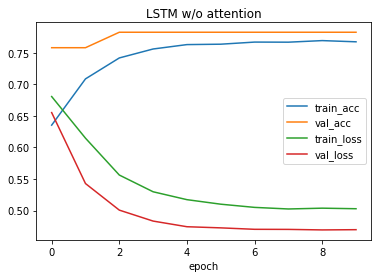

In [0]:
plot_results(lstm_no_attention, title="LSTM w/o attention", val=True)

In [0]:
pseudo_labeling(lstm_no_attention, 5, 2, 64)

Train on 1055 samples, validate on 189 samples
Epoch 1/2
1055/1055 [==============================] - 44s 41ms/sample - loss: 0.4068 - acc: 0.8416 - val_loss: 0.5111 - val_acc: 0.7692
Epoch 2/2
237/237 [==============================] - 4s 17ms/sample - loss: 0.4854 - acc: 0.7801
Train on 1055 samples, validate on 189 samples
Epoch 1/2
1055/1055 [==============================] - 43s 41ms/sample - loss: 0.4011 - acc: 0.8416 - val_loss: 0.5055 - val_acc: 0.7692
Epoch 2/2
237/237 [==============================] - 4s 17ms/sample - loss: 0.4797 - acc: 0.7801
Train on 1055 samples, validate on 189 samples
Epoch 1/2


KeyboardInterrupt: ignored

In [0]:
# Create LSTM with Attention using Keras Functional API
# (https://stackoverflow.com/questions/42918446/how-to-add-an-attention-mechanism-in-keras)
def create_lstm_with_attention():
    _input = Input(shape=[MAX_LENGTH])
    embedded = Embedding(
            input_dim=NUM_CHARS,
            output_dim=EMBEDDING_SIZE,
            input_length=MAX_LENGTH,
            trainable=False,
            mask_zero=False
        )(_input)
    activations = LSTM(HIDDEN_SIZE)(embedded)
    activations = Dropout(0.5)(activations)
    
    # Attention
    attention = Dense(1, activation='tanh')(activations) # 'softmax'
    # attention = Dense(1)(attention)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(HIDDEN_SIZE)(attention)
    attention = Permute([2, 1])(attention)
    output_attention = multiply([activations, attention])

    # output_attention = LSTM(HIDDEN_SIZE)(output_attention)

    output_attention = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(HIDDEN_SIZE,))(output_attention)
    output = Dense(NUM_ADR_CLASSES, activation='sigmoid')(output_attention)
    lstm_attention = Model(inputs=[_input], outputs=output, name="lstm_attention")
    return lstm_attention

In [0]:
lstm_attention = create_lstm_with_attention()
# adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_attention.summary())

lstm_attention.fit(X_train, y_train,
# lstm_attention.fit(X_train_main, y_train_main,
#                          validation_data=(X_train_val, y_train_val),
                         epochs=10, batch_size=64)

Model: "lstm_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 1695)]       0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 1695, 64)     8192        input_27[0][0]                   
__________________________________________________________________________________________________
lstm_23 (LSTM)                  (None, 50)           23000       embedding_36[0][0]               
__________________________________________________________________________________________________
dropout_69 (Dropout)            (None, 50)           0           lstm_23[0][0]                    
_____________________________________________________________________________________

In [0]:
lstm_attention.evaluate(X_test, y_test)

237/237 [==============================] - 4s 18ms/sample - loss: 0.4694 - acc: 0.7801


[0.46937746538894587, 0.78012186]

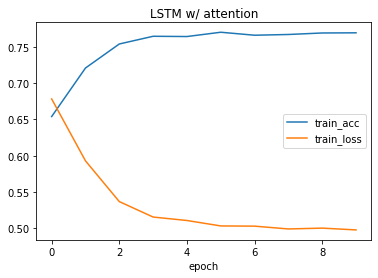

In [0]:
plot_results(lstm_attention, title="LSTM w/ attention")

In [0]:
# Create Encoder Decoder with Attention using Keras Functional API
# (https://stackoverflow.com/questions/42918446/how-to-add-an-attention-mechanism-in-keras)
HIDDEN_SIZE=10
def create_enc_dec_with_attention():
    _input = Input(shape=[MAX_LENGTH])
    embedded = Embedding(
            input_dim=NUM_CHARS,
            output_dim=EMBEDDING_SIZE,
            input_length=MAX_LENGTH,
            trainable=False,
            mask_zero=False
        )(_input)
    activations = LSTM(HIDDEN_SIZE, return_sequences=True)(embedded)
    activations = Dropout(0.5)(activations)
    activations = LSTM(HIDDEN_SIZE, return_sequences=True)(activations)
    
    # Attention
    attention = Dense(1, activation='tanh')(activations) # 'softmax'
    # attention = Dense(1)(attention)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(HIDDEN_SIZE)(attention)
    attention = Permute([2, 1])(attention)
    output_attention = multiply([activations, attention])
    output_attention = LSTM(HIDDEN_SIZE, return_sequences=True)(output_attention)
    output_attention = Dropout(0.5)(activations)
    output_attention = LSTM(HIDDEN_SIZE)(output_attention)
    output = Dense(NUM_ADR_CLASSES, activation='sigmoid')(output_attention)
    lstm_attention = Model(inputs=[_input], outputs=output, name="enc_dec")
    return lstm_attention

In [0]:
enc_dec = create_enc_dec_with_attention()
enc_dec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(enc_dec.summary())

enc_dec.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=5, batch_size=64)

Model: "enc_dec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1695)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1695, 64)          8192      
_________________________________________________________________
lstm_7 (LSTM)                (None, 1695, 10)          3000      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1695, 10)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1695, 10)          840       
_________________________________________________________________
dropout_10 (Dropout)         (None, 1695, 10)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10)                840 

In [0]:
enc_dec.evaluate(X_test, y_test)

237/237 [==============================] - 11s 47ms/sample - loss: 0.5729 - acc: 0.7436


[0.5728622335421888, 0.74355364]

In [0]:
# Bidirectional LSTM without Attention (https://keras.io/examples/imdb_bidirectional_lstm/)
bi_lstm_no_attention = Sequential()
bi_lstm_no_attention.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
bi_lstm_no_attention.add(Bidirectional(LSTM(HIDDEN_SIZE)))
bi_lstm_no_attention.add(Dropout(0.5))

bi_lstm_no_attention.add(Dense(NUM_ADR_CLASSES, activation='sigmoid'))
bi_lstm_no_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_lstm_no_attention.summary())

bi_lstm_no_attention.fit(X_train, y_train,
# bi_lstm_no_attention.fit(X_train_main, y_train_main,
#                          validation_data=(X_train_val, y_train_val),
                         epochs=10, batch_size=64)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 1695, 64)          8192      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               46000     
_________________________________________________________________
dropout_72 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 27)                2727      
Total params: 56,919
Trainable params: 56,919
Non-trainable params: 0
_________________________________________________________________
None
Train on 944 samples
Epoch 1/10
944/944 [==============================] - 87s 92ms/sample - loss: 0.6693 - acc: 0.6851
Epoch 2/10
944/944 [==============================] - 85s 90ms/sample - loss: 0.5534 - acc: 0.7560
Epoch 3/10
944/944 [===

In [0]:
bi_lstm_no_attention.evaluate(X_test, y_test)

237/237 [==============================] - 8s 34ms/sample - loss: 0.4657 - acc: 0.7798


[0.4656837044385918, 0.77980936]

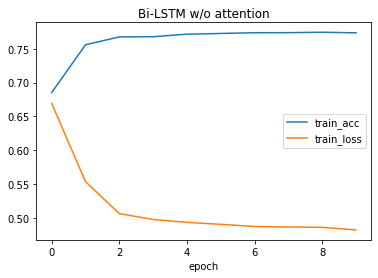

In [0]:
plot_results(bi_lstm_no_attention, title="Bi-LSTM w/o attention")

In [0]:
# create Bidirectional LSTM with Attention using Keras Functional API
def create_bi_lstm_with_attention():
    _input = Input(shape=[MAX_LENGTH])
    embedded = Embedding(
            input_dim=NUM_CHARS,
            output_dim=EMBEDDING_SIZE,
            input_length=MAX_LENGTH,
            trainable=False,
            mask_zero=False
        )(_input)
    activations = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(embedded)
    activations = Dropout(0.5)(activations)
    # Attention
    attention = Dense(1, activation='tanh')(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(2*HIDDEN_SIZE)(attention)
    attention = Permute([2, 1])(attention)
    output_attention = multiply([activations, attention])

    # output_attention = LSTM(HIDDEN_SIZE)(output_attention)
    output_attention = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(HIDDEN_SIZE,))(output_attention)
    output = Dense(NUM_ADR_CLASSES, activation='sigmoid')(output_attention)
    bi_lstm_attention = Model(inputs=[_input], outputs=output, name="bi_lstm_attention")
    return bi_lstm_attention

In [209]:
bi_lstm_attention = create_bi_lstm_with_attention()
bi_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_lstm_attention.summary())

bi_lstm_attention.fit(X_train, y_train,
# bi_lstm_attention.fit(X_train_main, y_train_main,
#                          validation_data=(X_train_val, y_train_val),
                         epochs=10, batch_size=64)

Model: "bi_lstm_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 1695)]       0                                            
__________________________________________________________________________________________________
embedding_42 (Embedding)        (None, 1695, 64)     8192        input_31[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 1695, 100)    46000       embedding_42[0][0]               
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 1695, 100)    0           bidirectional_4[0][0]            
__________________________________________________________________________________

In [210]:
bi_lstm_attention.evaluate(X_test, y_test)

237/237 [==============================] - 8s 34ms/sample - loss: 0.4671 - acc: 0.7801


[0.46712367519547665, 0.78012186]

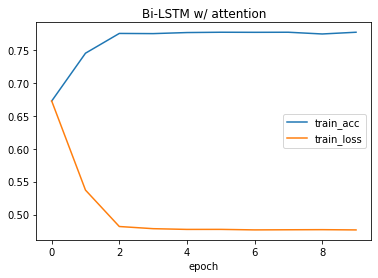

In [211]:
plot_results(bi_lstm_attention, title="Bi-LSTM w/ attention")

In [219]:
# MLP
MLP_HIDDEN_SIZE = 64

mlp = Sequential()
mlp.add(Input(shape=(MAX_LENGTH,)))
mlp.add(Dense(MLP_HIDDEN_SIZE, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(MLP_HIDDEN_SIZE, activation='relu'))  # 'tanh'
mlp.add(Dropout(0.5))

mlp.add(Dense(NUM_ADR_CLASSES, activation='sigmoid'))

mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(mlp.summary())

mlp.fit(X_train, y_train,
# mlp.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=100, batch_size=64)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 64)                108544    
_________________________________________________________________
dropout_84 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 27)                1755      
Total params: 114,459
Trainable params: 114,459
Non-trainable params: 0
_________________________________________________________________
None
Train on 944 samples, validate on 189 samples
Epoch 1/100
944/944 [==============================] - 4s 4ms/

In [220]:
mlp.evaluate(X_test, y_test)

237/237 [==============================] - 0s 146us/sample - loss: 0.4864 - acc: 0.7804


[0.48638052427316014, 0.78043437]

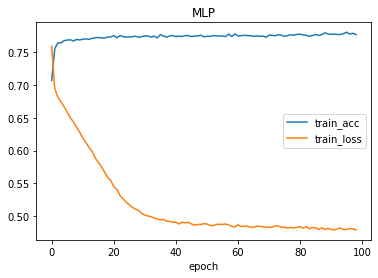

In [221]:
plot_results(mlp, title="MLP", mlp=True)

In [0]:
test_losses, test_accs = pseudo_labeling(mlp, 10, 50, 64)

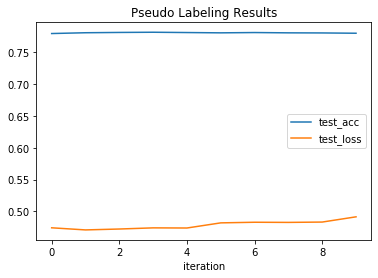

In [0]:
plt.figure()
plt.plot(test_accs)
plt.plot(test_losses)
plt.title('Pseudo Labeling Results')
plt.legend(['test_acc', 'test_loss'], loc = 'best')
plt.xlabel('iteration')
plt.show()

In [0]:
test_accs

[0.779653,
 0.7809033,
 0.7813721,
 0.7816846,
 0.7812157,
 0.780747,
 0.7812157,
 0.780747,
 0.78059065,
 0.78012186]

In [0]:
mlp_predictions = np.round(mlp.predict(X_test))
mlp_predictions[0]

array([1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

In [0]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [0]:
bi_lstm_predictions = np.round(bi_lstm_attention.predict(X_test))

In [0]:
lstm_predictions = np.round(lstm_attention.predict(X_test))

In [0]:
bi_lstm_no_attention_predictions = np.round(bi_lstm_no_attention.predict(X_test))

In [0]:
mlp_predictions = np.round(mlp.predict(X_test))

In [0]:
hamming_loss(mlp_predictions, y_test)

0.473511486169714

In [0]:
for i in range(len(bi_lstm_predictions)):
    # print(np.array_equal(bi_lstm_predictions[i], mlp_predictions[i]))
    print(sum(np.abs(np.subtract(mlp_predictions[i], y_test[i])))/27)

In [0]:
bi_lstm_predictions[0]

array([1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)